In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import tqdm
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from pygam import LogisticGAM, s, f, te
import xarray as xr
import glob
import netCDF4 as nc

In [2]:
def load_scws(rid,tz):
    print("loading "+rid+"...")
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,1:0,2:1})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    df1["month"] = df1.index.month
    df1["year"] = df1.index.year
    df1["aspect_ratio"] = df1.major_axis_length / df1.minor_axis_length    
    
    df2["cluster_new"] = df2.cluster.map({0:2,1:0,2:1})
    df2 = df2.set_index(pd.DatetimeIndex(df2.dt_utc))
    df2["month"] = df2.index.month
    df2["year"] = df2.index.year    
    df2["aspect_ratio"] = df2.major_axis_length / df2.minor_axis_length     
    
    df1["rid"] = rid
    df2["rid"] = rid

    
    return df1, df2

def train_binary_mod(df, classifier, preds, target):
    
    mod = classifier.fit(df[preds], df[target].values.ravel())
    
    return mod

def train_test_binary_mod(df, classifier, preds, target, n_split, test_size):
    
    auc_scores = []
    for train, test in tqdm.tqdm(StratifiedShuffleSplit(n_split,test_size=test_size).split(X=df[preds],y=df[target].values.ravel())):
        mod_split = train_binary_mod(df.iloc[train], classifier, preds, target)
        auc_scores.append(roc_auc_score(df.iloc[test][target],mod_split.predict_proba(df.iloc[test][preds])[:,1]))
        
    return auc_scores

def train_test_multi_mod(df, classifier, preds, target, n_split, test_size):
    
    auc_scores = []
    for train, test in tqdm.tqdm(StratifiedShuffleSplit(n_split,test_size=test_size).split(X=df[preds],y=df[target].values.ravel())):
        mod_split = train_binary_mod(df.iloc[train], classifier, preds, target)
        auc_scores.append(roc_auc_score(df.iloc[test][target],mod_split.predict_proba(df.iloc[test][preds]),multi_class="ovr",
                                       average="weighted"))
        
    return auc_scores

In [3]:
melb_scw, melb_null = load_scws("2",'Australia/Melbourne')
bris_scw, bris_null = load_scws("66",'Australia/Brisbane')
namoi_scw, namoi_null = load_scws("69",'Australia/Sydney')
perth_scw, perth_null = load_scws("70",'Australia/Perth')
syd_scw, syd_null = load_scws("71",'Australia/Sydney')

loading 2...
loading 66...
loading 69...
loading 70...
loading 71...


In [4]:
data=pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw,
               ], axis=0)
data["scw"]=1
data_null=pd.concat([melb_null, 
                     syd_null, 
                     bris_null,
                     perth_null, 
                     namoi_null], axis=0)
data = pd.concat([data,data_null],axis=0).set_index("stn_id",append=True)

#Linear
data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
#Non-linear
data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
#Cellular
data.loc[(data.local_max == 1),"class2"] = "Cellular"
#Cluster of cells
data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
#Supercell
data.loc[(data.azi_shear60>4) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
#Linear hybrid
data.loc[(data.azi_shear60>4) & ((data.major_axis_length>=100)),"class2"] = "Embedded supercell"

In [5]:
data_storm = data[data.in10km==1].dropna(subset=["azi_shear60"])

In [6]:
data["scw_lightning"] = np.where((data.scw==1) & (data.Lightning_observed>=2), 1, 0) 
data_storm["scw_lightning"] = np.where((data_storm.scw==1) & (data_storm.Lightning_observed>=2), 1, 0) 

In [7]:
print("AUC scores using all nulls, for events with and without lightning\nNote this is one-hourly lightning data\n")
print("AUC using the model wind gust:",roc_auc_score(data["scw"],data["wg10"]),roc_auc_score(data["scw_lightning"],data["wg10"]))
print("AUC using CAPE:",roc_auc_score(data["scw"],data["mu_cape"]),roc_auc_score(data["scw_lightning"],data["mu_cape"]))
print("AUC using DCP:",roc_auc_score(data["scw"],data["dcp"]),roc_auc_score(data["scw_lightning"],data["dcp"]))
print("AUC using total totals:",roc_auc_score(data["scw"],data["t_totals"]),roc_auc_score(data["scw_lightning"],data["t_totals"]))
print("AUC using BDSD:",roc_auc_score(data["scw"],data["bdsd"]),roc_auc_score(data["scw_lightning"],data["bdsd"]))

AUC scores using all nulls, for events with and without lightning
Note this is one-hourly lightning data

AUC using the model wind gust: 0.8926264367857311 0.7992097710478427
AUC using CAPE: 0.8027452933631913 0.9264361622421899
AUC using DCP: 0.8405060830316055 0.9479967601047441
AUC using total totals: 0.8615260175908874 0.9190924147182291
AUC using BDSD: 0.9637476817739912 0.9704330453722186


In [8]:
print("AUC scores using storm events as nulls, for events with and without lightning\nNote this is one-hourly lightning data\n")
print("AUC using the model wind gust:",roc_auc_score(data_storm["scw"],data_storm["wg10"]),roc_auc_score(data_storm["scw_lightning"],data_storm["wg10"]))
print("AUC using CAPE:",roc_auc_score(data_storm["scw"],data_storm["mu_cape"]),roc_auc_score(data_storm["scw_lightning"],data_storm["mu_cape"]))
print("AUC using DCP:",roc_auc_score(data_storm["scw"],data_storm["dcp"]),roc_auc_score(data_storm["scw_lightning"],data_storm["dcp"]))
print("AUC using total totals:",roc_auc_score(data_storm["scw"],data_storm["t_totals"]),roc_auc_score(data_storm["scw_lightning"],data_storm["t_totals"]))
print("AUC using BDSD:",roc_auc_score(data_storm["scw"],data_storm["bdsd"]),roc_auc_score(data_storm["scw_lightning"],data_storm["bdsd"]))

AUC scores using storm events as nulls, for events with and without lightning
Note this is one-hourly lightning data

AUC using the model wind gust: 0.7929846671005012 0.6542237349880801
AUC using CAPE: 0.6339679537386057 0.8551684613476567
AUC using DCP: 0.7293961523466391 0.8993641558920018
AUC using total totals: 0.6882074682678883 0.7811731099015807
AUC using BDSD: 0.8145732963627652 0.8512113700734296


In [43]:
gam_preds = ["ebwd","Umean800_600","lr13","max_alt","field_max"]

resample_null = resample(data_storm[data_storm["scw"]==0],replace=True,n_samples=data_storm["scw"].sum()*10,random_state=10)
resampled = pd.concat([resample_null, data_storm[data_storm["scw"]==1]], axis=0)



In [45]:
gam = LogisticGAM(s(0)+s(1)+s(2)+s(3)+s(4),verbose=False,max_iter=1000).gridsearch(resampled[gam_preds].values,resampled["scw"])

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


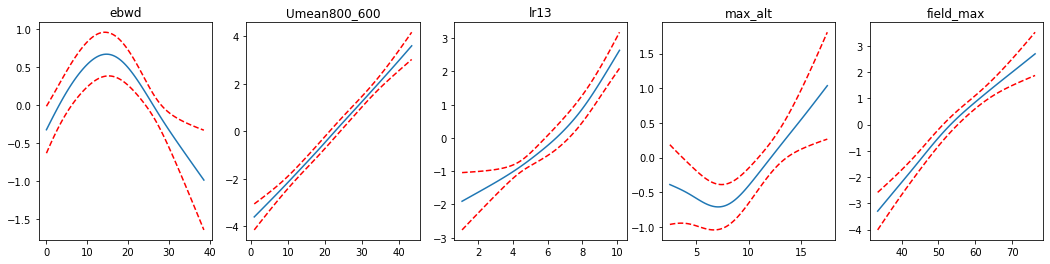

In [47]:
fig, axs = plt.subplots(1, 5,figsize=[18,4])
titles = gam_preds

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [48]:
roc_auc_score(resampled["scw"],gam.predict_proba(resampled[gam_preds]))

0.895517278183266

In [38]:
#Try with all predictors and let the decision tree decide. As in our JSHESS paper, this is all "variables" (not including indices)
rf_preds = np.array(['ml_cape', 'mu_cape', 'sb_cape',\
             'ml_cin', 'sb_cin', 'mu_cin', 'ml_lcl', 'mu_lcl', 'sb_lcl', 'eff_cape',\
             'eff_cin', 'eff_lcl', 'lr01', 'lr03', 'lr13', 'lr36', 'lr24', 'lr_freezing',\
             'lr_subcloud', 'qmean01', 'qmean03', 'qmean06', 'qmeansubcloud', 'q_melting',\
             'q1', 'q3', 'q6', 'rhmin01', 'rhmin03', 'rhmin13', 'rhminsubcloud', 'tei', 'wbz',\
             'mhgt', 'mu_el', 'ml_el', 'sb_el', 'eff_el', 'pwat', \
             'te_diff', 'dpd850', 'dpd700', 'dcape', 'ddraft_temp', 'sfc_thetae',\
             'srhe_left', 'srh01_left', 'srh03_left', 'srh06_left', 'ebwd', 's010', 's06',\
             's03', 's01', 's13', 's36', 'scld', 'U500', 'U10', 'U1', 'U3', 'U6', 'Ust_left',\
             'Usr01_left', 'Usr03_left', 'Usr06_left', 'Uwindinf', 'Umeanwindinf',\
             'Umean800_600', 'Umean06', 'Umean01', 'Umean03',\
            "max_alt","area_km","speed","field_max"])
rf = BalancedRandomForestClassifier(n_estimators=500,
                                             max_depth=None,
                                             sampling_strategy='majority',
                                             max_features="sqrt"
                                            )

In [39]:
resample_null = resample(data_storm[data_storm["scw"]==0],replace=True,n_samples=data_storm["scw"].sum()*10,random_state=10)
resampled = pd.concat([resample_null, data_storm[data_storm["scw"]==1]], axis=0)

mod = rf.fit(resampled[rf_preds], resampled["scw"].values.ravel())


In [40]:
pd.DataFrame({"fi":mod.feature_importances_},index=rf_preds).sort_values("fi",ascending=False).iloc[0:20]

,fi
U10,0.050116
field_max,0.047769
lr_freezing,0.038153
Umean01,0.037902
lr03,0.035693
Umean03,0.034106
max_alt,0.030503
ddraft_temp,0.028434
U1,0.026798
sb_lcl,0.025128


In [41]:
roc_auc_score(resampled["scw"],mod.predict_proba(resampled[rf_preds])[:,1])

0.9952586596169162

In [42]:
mod.predict_proba(resampled[rf_preds])

array([[0.962, 0.038],
       [0.922, 0.078],
       [0.808, 0.192],
       ...,
       [0.08 , 0.92 ],
       [0.044, 0.956],
       [0.058, 0.942]])